In [10]:
import gc
import os
import time
import datetime
import warnings
from itertools import combinations
from warnings import simplefilter
import lightgbm as lgb
import catboost as cbt

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error 
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [11]:
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Please use caps lock capital letters while filling in parameters
    """
    
    # Data preparation
    version_nb         = 3
    is_gpu             = True
    # device             = torch.device('cuda' if torch.cuda.is_available() and gpu_switch else 'cpu')
    state              = 42
    num_workers        = 4

    # BEFORE SUBMIT, CHECK SETTINGS
    is_test_mode       = True
    test_mode_frac     = 10
    is_offline         = True
    is_tuning          = True
    testing_days       = 2

    target             = 'target'    
    path               = '/kaggle/input/optiver-trading-at-the-close'
    train_path         = f'{path}/train.csv'
    test_path          = f'{path}/example_test_files/test.csv'
    model_path         = f'' if not is_offline else f'{path}/'
    
    TRAINING           = True
    INFERENCE          = False
    TUNING             = True
    
    methods            = ['LGBM',]
    # methods            = ['CBT']

    plt_path = f'fig/turning'

# Data Loading and Preprocessing 






In [12]:
# 📂 Read the dataset from a CSV file using Pandas
df = pd.read_csv(CFG.train_path)
if CFG.is_test_mode:
    df = df[df['stock_id'] < CFG.test_mode_frac]

# 🧹 Remove rows with missing values in the "target" column
df = df.dropna(subset=["target"])

# 🔁 Reset the index of the DataFrame and apply the changes in place
df.reset_index(drop=True, inplace=True)

# 📏 Get the shape of the DataFrame (number of rows and columns)
df_shape = df.shape
print(df_shape)

(264550, 17)


# Memory Optimization

In [13]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df

 # Parallel Triplet Imbalance Calculation

In [14]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features

# Feature Generation Functions 

In [15]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    df["size_imbalance_bid"] = df.eval("imbalance_size / bid_size")
    df["size_imbalance_ask"] = df.eval("imbalance_size / ask_size")
    df["matched_size_bid_ask"] = df.eval("matched_size / (bid_size+ask_size)")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)

            if window == 1:
                continue

            date_ids = df['date_id'].unique()
            agg_func = ['mean', 'sum']
            moving_li = []
            
            for date in date_ids:
                moving_li.append(
                    df[df['date_id'] == date].groupby('stock_id')[col].rolling(window).agg(agg_func).reset_index().set_index('level_1')[agg_func]
                )
            df[[f'{col}_moving_average_{window}', f'{col}_moving_sum_{window}']] = pd.concat(moving_li)[agg_func]
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'market_urgency', 'imbalance_momentum', 'size_imbalance']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    # --- add
    # Calculate diff prices
    for c in combinations(prices, 2):
        df[f'{c[0]}_{c[1]}_diff'] = df.eval(f'({c[0]} - {c[1]})')

    return df.replace([np.inf, -np.inf], 0)

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df, feature_name=None):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    df = other_features(df)
    gc.collect()

    if not feature_name:
        feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id", 'ask_price_bid_price_diff']]
    
    return df[feature_name]

In [16]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

## Data Splitting

In [17]:
df_train = df.copy()
del df

In [18]:
global_stock_id_feats = {
    "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
    "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
    "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
    "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
    "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
    "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
}
if CFG.TRAINING:
    df_train_feats = generate_all_features(df_train)
    df_train_feats = reduce_mem_usage(df_train_feats)

    feature_name = list(df_train_feats.columns)
    print(f'Feature length = {len(feature_name)}')

Feature length = 165


In [20]:
model = lgb.Booster(model_file='/kaggle/input/optiver-trading-at-the-close/lgb_model/lgb_fin.txt')

In [23]:
# 特徴量重要度の取得
importances = model.feature_importance(importance_type='gain')
feature_names = df_train_feats.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'val': importances}).set_index('feature').sort_values('val', ascending=False)

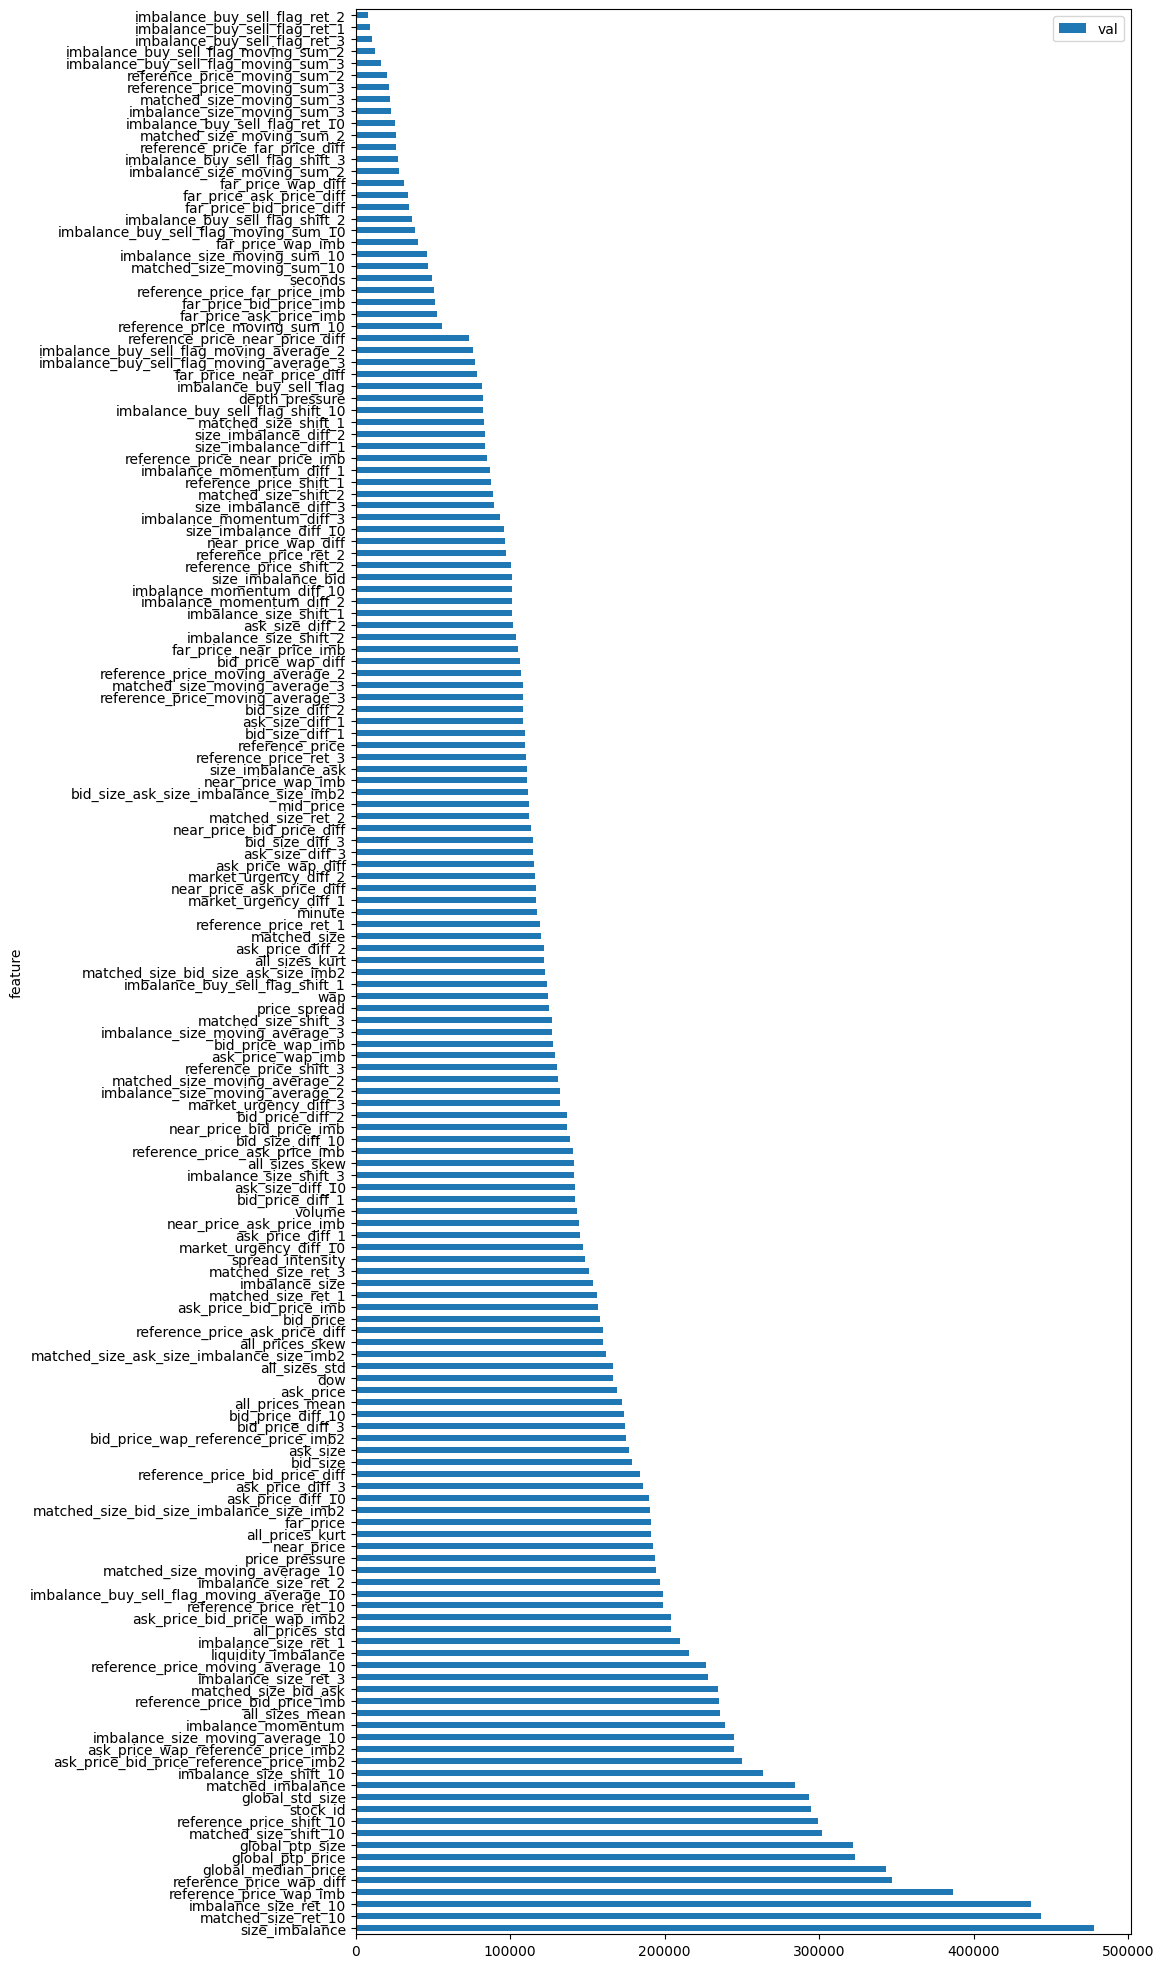

In [26]:
fig = feature_importances[feature_importances['val'] < 5e5].plot.barh(figsize=(10, 25))

In [25]:
feature_importances.loc[['reference_price_moving_sum_10']]

,val
feature,
reference_price_moving_sum_10,56131.337796


In [31]:
threshold_features = feature_importances[feature_importances['val'] > 57000].index.values

In [1]:
# with pd.option_context('display.max_rows', 300):
#     display(feature_importances)

NameError: name 'pd' is not defined

In [38]:
rfe_features = ['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'far_price', 'near_price',
       'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'mid_price',
       'matched_imbalance', 'size_imbalance', 'size_imbalance_ask',
       'matched_size_bid_ask', 'reference_price_ask_price_imb',
       'reference_price_bid_price_imb', 'reference_price_wap_imb',
       'far_price_near_price_imb', 'near_price_ask_price_imb',
       'near_price_bid_price_imb', 'near_price_wap_imb',
       'ask_price_bid_price_imb', 'bid_price_wap_imb',
       'ask_price_bid_price_wap_imb2',
       'ask_price_bid_price_reference_price_imb2',
       'ask_price_wap_reference_price_imb2',
       'bid_price_wap_reference_price_imb2',
       'matched_size_bid_size_imbalance_size_imb2',
       'matched_size_ask_size_imbalance_size_imb2', 'imbalance_momentum',
       'price_spread', 'spread_intensity', 'price_pressure', 'market_urgency',
       'all_prices_mean', 'all_sizes_mean', 'all_prices_std', 'all_sizes_std',
       'all_prices_skew', 'all_sizes_skew', 'all_prices_kurt',
       'all_sizes_kurt', 'matched_size_ret_1', 'matched_size_moving_average_2',
       'matched_size_shift_3', 'matched_size_ret_3',
       'matched_size_moving_average_3', 'matched_size_shift_10',
       'matched_size_ret_10', 'matched_size_moving_average_10',
       'imbalance_size_ret_1', 'imbalance_size_ret_2',
       'imbalance_size_moving_average_2', 'imbalance_size_shift_3',
       'imbalance_size_ret_3', 'imbalance_size_moving_average_3',
       'imbalance_size_shift_10', 'imbalance_size_ret_10',
       'imbalance_size_moving_average_10', 'reference_price_ret_1',
       'reference_price_moving_average_3', 'reference_price_shift_10',
       'reference_price_ret_10', 'reference_price_moving_average_10',
       'imbalance_buy_sell_flag_shift_1',
       'imbalance_buy_sell_flag_moving_average_2',
       'imbalance_buy_sell_flag_moving_average_3',
       'imbalance_buy_sell_flag_shift_10',
       'imbalance_buy_sell_flag_moving_average_10', 'ask_price_diff_1',
       'ask_price_diff_2', 'ask_price_diff_3', 'ask_price_diff_10',
       'bid_price_diff_1', 'bid_price_diff_2', 'bid_price_diff_3',
       'bid_price_diff_10', 'market_urgency_diff_1', 'market_urgency_diff_2',
       'market_urgency_diff_3', 'market_urgency_diff_10',
       'reference_price_near_price_diff', 'reference_price_ask_price_diff',
       'reference_price_bid_price_diff', 'reference_price_wap_diff',
       'far_price_near_price_diff', 'far_price_ask_price_diff',
       'near_price_ask_price_diff', 'near_price_bid_price_diff',
       'near_price_wap_diff', 'dow', 'global_median_size', 'global_std_size',
       'global_ptp_size', 'global_median_price', 'global_std_price',
       'global_ptp_price']
len(rfe_features)

100

In [43]:
featurelist(set(rfe_features) & set(threshold_features))

['reference_price_ask_price_imb',
 'bid_size',
 'matched_size_moving_average_10',
 'far_price_near_price_imb',
 'near_price_wap_diff',
 'all_sizes_kurt',
 'near_price_bid_price_imb',
 'near_price_wap_imb',
 'matched_size_moving_average_2',
 'mid_price',
 'size_imbalance_ask',
 'imbalance_buy_sell_flag_moving_average_2',
 'near_price',
 'reference_price_wap_diff',
 'wap',
 'global_median_price',
 'all_prices_skew',
 'imbalance_size_ret_3',
 'ask_price_bid_price_imb',
 'all_sizes_mean',
 'bid_price_wap_imb',
 'global_ptp_price',
 'bid_price_diff_10',
 'global_ptp_size',
 'matched_imbalance',
 'matched_size_ret_1',
 'imbalance_buy_sell_flag_moving_average_10',
 'global_std_price',
 'reference_price_ret_1',
 'reference_price_bid_price_imb',
 'ask_price_bid_price_wap_imb2',
 'imbalance_buy_sell_flag_shift_10',
 'global_std_size',
 'imbalance_buy_sell_flag_shift_1',
 'size_imbalance',
 'market_urgency_diff_1',
 'global_median_size',
 'reference_price_bid_price_diff',
 'all_sizes_std',
 'mark